# Import

In [1]:
# general imports
import glob
import os
from datetime import datetime
from dateutil.parser import parse
import shutil
import sys

# download
import drms
from urllib import request

# data processing
import numpy as np
from astropy.nddata import block_reduce
from sunpy.map import Map

# deep learning
import torch

# NF2
from nf2.train.trainer import NF2Trainer
from nf2.data.download import download_HARP, find_HARP, donwload_ds
from nf2.train.metric import *
from nf2.evaluation.unpack import load_cube
from nf2.evaluation.energy import get_free_mag_energy
from nf2.data.loader import load_hmi_data
from nf2.train.metric import energy

# visualization
from matplotlib import pyplot as plt

In [16]:
# Kusano NLFFF
import netCDF4

from NLFFF.load_nlfff import nlfff

In [4]:
device = torch.device('mps') if torch.cuda.is_available() else torch.device('cpu')

# Path

In [7]:
# AR 12673 - 20170906_083600
nf2_path = './database/author/example_7115.nf2'
npy_path = './12673_20170906_083600.npy'
nc_path = './12673_20170906_083600.nc'
hmi_r = './AR_7115_series/hmi.sharp_cea_720s.7115.20170906_083600_TAI.Br.fits'

In [5]:
# AR 11158 - 20110213_120000
nf2_path = './ar_series_377_2011-02-12T00:00:00/base/20110213_120000_TAI/extrapolation_result.nf2'
npy_path = './database/11158_20110213_120000.npy'
nc_path = './database/11158_20110213_120000.nc'
hmi_r = './AR_377_series/hmi.sharp_cea_720s.377.20110213_120000_TAI.Br.fits'

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


Observatory,SDO
Instrument,HMI SIDE1
Detector,HMI
Measurement,hmi
Wavelength,6173.0 Angstrom
Observation Date,2011-02-13 11:58:12
Exposure Time,Unknown
Dimension,[744. 377.] pix
Coordinate System,heliographic_carrington
Scale,[0.03 0.03] deg / pix
Reference Pixel,[371.5 188. ] pix

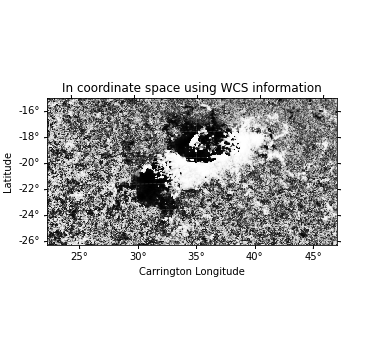
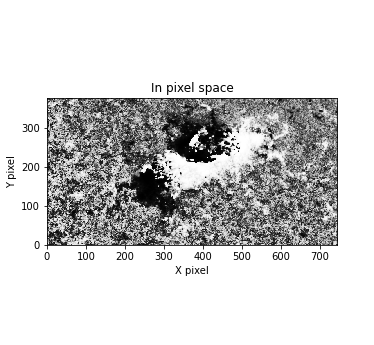
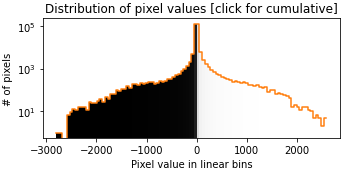
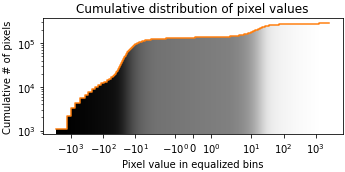

In [ ]:
Map(hmi_r)

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


Observatory,SDO
Instrument,HMI COMBINED
Detector,HMI
Measurement,hmi
Wavelength,6173.0 Angstrom
Observation Date,2017-09-06 08:34:42
Exposure Time,Unknown
Dimension,[688. 448.] pix
Coordinate System,heliographic_carrington
Scale,[0.03 0.03] deg / pix
Reference Pixel,[343.5 223.5] pix

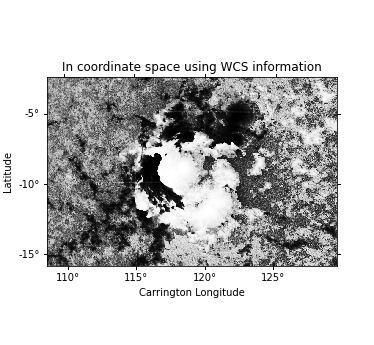
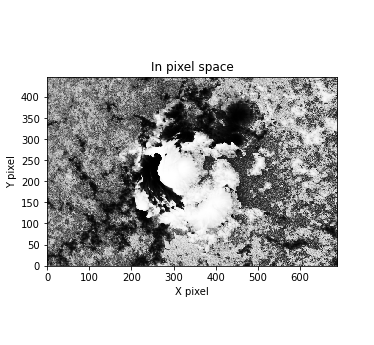
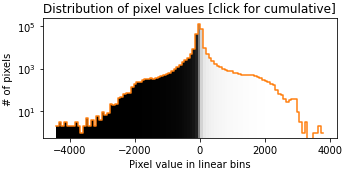
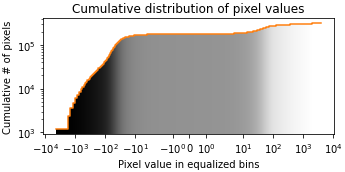

In [ ]:
Map(hmi_r)

# nf2 -> npy (time-consuming)

In [8]:
state = torch.load(nf2_path, map_location=device)

In [9]:
state

{'model': BModel(
   (d_in): Linear(in_features=3, out_features=256, bias=True)
   (linear_layers): ModuleList(
     (0): Linear(in_features=256, out_features=256, bias=True)
     (1): Linear(in_features=256, out_features=256, bias=True)
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): Linear(in_features=256, out_features=256, bias=True)
     (4): Linear(in_features=256, out_features=256, bias=True)
     (5): Linear(in_features=256, out_features=256, bias=True)
     (6): Linear(in_features=256, out_features=256, bias=True)
     (7): Linear(in_features=256, out_features=256, bias=True)
   )
   (d_out): Linear(in_features=256, out_features=3, bias=True)
   (activation): Sine()
 ),
 'cube_shape': [344, 224, 160],
 'b_norm': 2500,
 'spatial_norm': 160,
 'meta_info': MetaDict([('simple', True),
           ('bitpix', 32),
           ('naxis', 2),
           ('naxis1', 688),
           ('naxis2', 448),
           ('pcount', 0),
           ('gcount', 1),
           ('xt

In [10]:
meta_info = state['meta_info']

# Number
print(meta_info['harpnum'])
print(meta_info['noaa_ar'])

# Observation
print(meta_info['date-obs'])
print(meta_info['t_obs'])
print(meta_info['t_rec'])

# shape
print(state['cube_shape'])
print(meta_info['naxis1'], meta_info['naxis2'])

7115
12673
2017-09-06T08:34:42.100
2017.09.06_08:36:04.065_TAI
2017.09.06_08:36:00.000_TAI
[344, 224, 160]
688 448


In [11]:
b = load_cube(nf2_path, device, progress=True, strides=1)

100%|████████████████████████████████████| 12329/12329 [00:53<00:00, 229.08it/s]


In [12]:
np.save(npy_path, b)

# Read npy

In [13]:
B = np.load(npy_path)

In [14]:
Bx = B[:, :, :, 0]
By = B[:, :, :, 1]
Bz = B[:, :, :, 2]

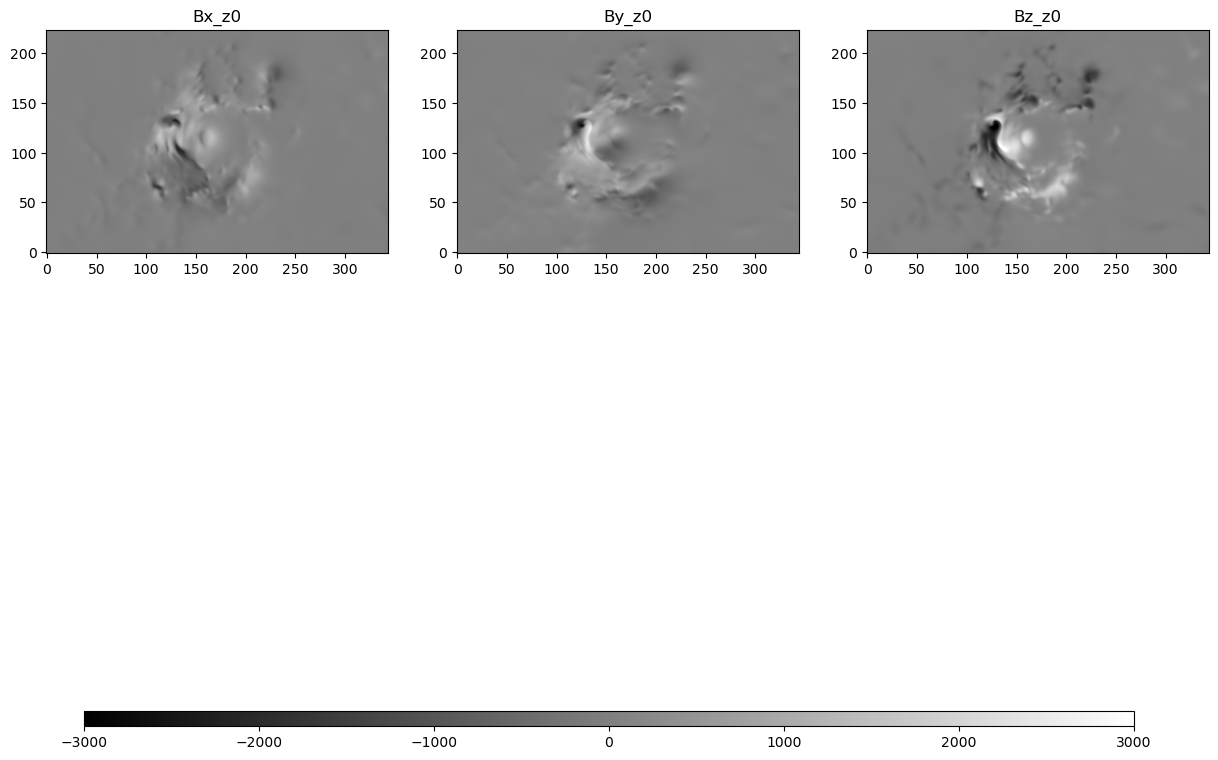

In [15]:
Bx_z0 = Bx[:, :, 0].transpose()
By_z0 = By[:, :, 0].transpose()
Bz_z0 = Bz[:, :, 0].transpose()

vmax = 3000
vmin = -3000

fig, axes = plt.subplots(1,3, figsize=(15, 15))
im = axes[0].imshow(Bx_z0, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[0].set_title('Bx_z0')
axes[1].imshow(By_z0, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[1].set_title('By_z0')
axes[2].imshow(Bz_z0, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
axes[2].set_title('Bz_z0')

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.15, 0.7, 0.01])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

# Read nc

In [18]:
nlff = nlfff(nc_path)

x (westward)  unit: Mm
y (northward)  unit: Mm
z (out ot photosphere)  unit: Mm
Bx (westward)  unit: G
By (northward)  unit: G
Bz (out of photosphere)  unit: G
Bx_pot (westward)  unit: G
By_pot (northward)  unit: G
Bz_pot (out of photosphere)  unit: G


In [19]:
nlff.info()

NOAA 12673
year_month_day_time 2017_9_6_83600
project ISEE Database for Nonlinear Force-Free Field of Solar Active Region
production_date 2021.12.08
version v1.1
data_doi 10.34515/DATA.HSC-00000
http_link https://hinode.isee.nagoya-u.ac.jp/nlfff_database/
Distributor Hinode Science Center, Institute for Space-Earth Environmental Research, Nagoya University


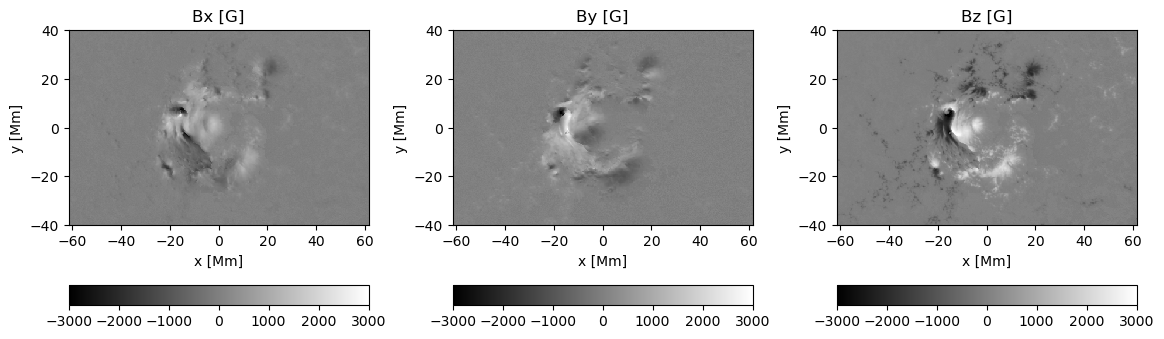

In [20]:
nlff.plot()

In [ ]:
#bstack = np.stack([nlff.bx, nlff.by, nlff.bz], axis=-1)
#np.array_equal(bstack[..., 0], nlff.bx)
#bstack.shape
#np.save(ncnpy_path, bstack)

# npy VS nc

In [ ]:
Br = Map(hmi_r).data

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]
See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards.


Text(0.5, 1.0, 'Observation (Br)')

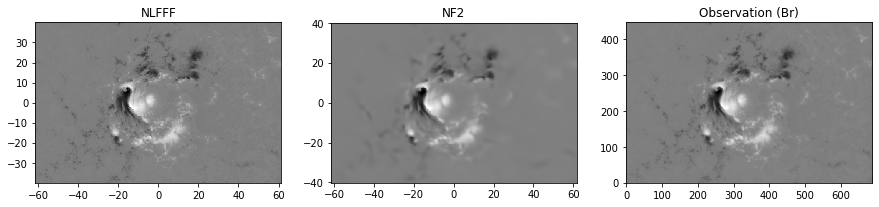

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
axes[0].pcolormesh(nlff.x, nlff.y, nlff.bz[:,:,0].transpose(), vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[0].set_aspect('equal')
axes[0].set_title('NLFFF')

ny, nx = np.shape(Bz_z0)
bin = 1
Mm_per_pixel = 360e-3 * bin
x = np.arange(nx) * Mm_per_pixel
x = x - max(x)/2
y = np.arange(ny) * Mm_per_pixel
y = y - max(y)/2
axes[1].pcolormesh(x, y, Bz[:,:,0].transpose(), vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[1].set_aspect('equal')
axes[1].set_title('NF2')

axes[2].imshow(Br, origin='lower', cmap='gist_gray', vmin=vmin, vmax=vmax)
axes[2].set_title('Observation (Br)')

In [ ]:
print(max(nlff.x) - min(nlff.x))
print(max(x) - min(x))

print(max(nlff.y) - min(nlff.y))
print(max(y) - min(y))

122.77860546844127
123.47999999999999
79.94885981210871
80.28


In [ ]:
print(len(nlff.x), len(nlff.y), len(nlff.z)) #NLFFF
print(state['cube_shape']) #NF2
print(meta_info['naxis1'], meta_info['naxis2']) #Original

513 257 257
[296, 184, 160]
744 377


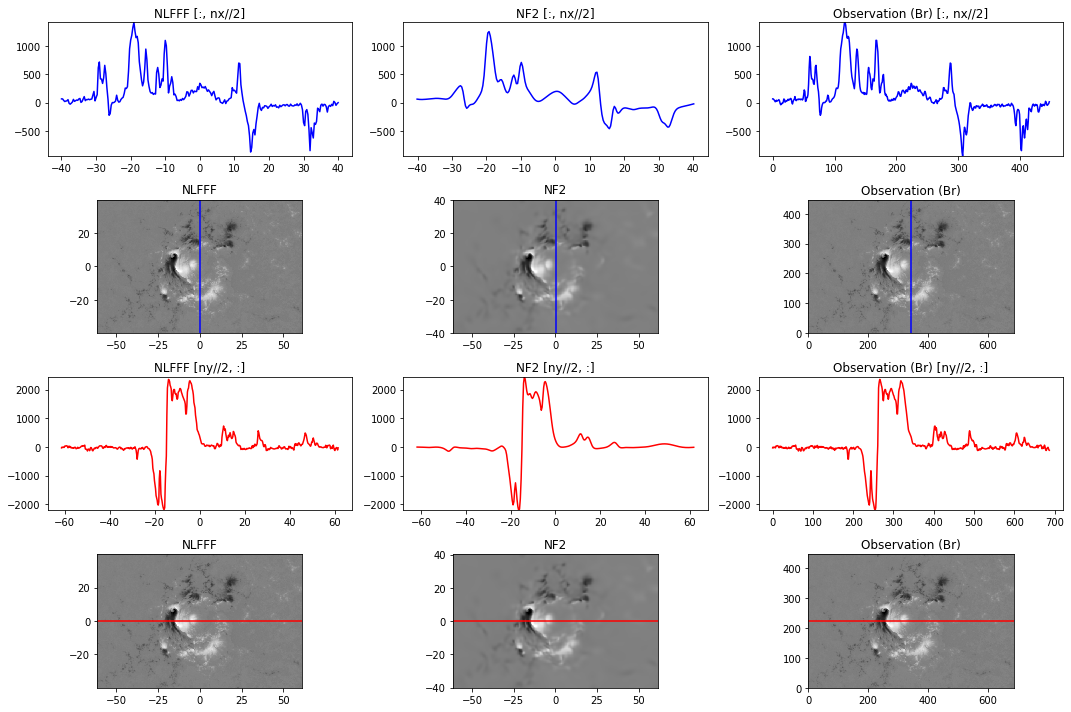

In [ ]:
nlf0 = nlff.bz[:,:,0].transpose()
ny1, nx1 = np.shape(nlf0)

nf20 = Bz[:,:,0].transpose()
ny2, nx2 = np.shape(nf20)

ob0 = Br
ny3, nx3 = np.shape(ob0)

max1 = max(max(nlf0[:, nx1//2]), max(nf20[:, nx2//2]), max(ob0[:, nx3//2]))
min1 = min(min(nlf0[:, nx1//2]), min(nf20[:, nx2//2]), min(ob0[:, nx3//2]))

max2 = max(max(nlf0[ny1//2, :]), max(nf20[ny2//2, :]), max(ob0[ny3//2, :]))
min2 = min(min(nlf0[ny1//2, :]), min(nf20[ny2//2, :]), min(ob0[ny3//2, :]))

fig, axes = plt.subplots(4,3, figsize=(15, 10))

#---------------------------------------------
x = nlfff.x
y = nlfff.y

axes[0,0].plot(nlff.y, nlf0[:, nx1//2], color='blue')
axes[0,0].set_title('NLFFF [:, nx//2]')
axes[0,0].set_ylim((min1, max1))

axes[1,0].pcolormesh(x, y, nlf0, vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[1,0].set_aspect('equal')
axes[1,0].set_title('NLFFF')
axes[1,0].axvline(x[nx1//2], color='blue')

axes[2,0].plot(x, nlf0[ny1//2, :], color='red')
axes[2,0].set_title('NLFFF [ny//2, :]')
axes[2,0].set_ylim((min2, max2))

axes[3,0].pcolormesh(x, y, nlf0, vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[3,0].set_aspect('equal')
axes[3,0].set_title('NLFFF')
axes[3,0].axhline(y[ny1//2], color='red')

#---------------------------------------------
Mm_per_pixel = 360e-3
x = np.arange(nx2) * Mm_per_pixel
x = x - max(x)/2
y = np.arange(ny2) * Mm_per_pixel
y = y - max(y)/2

axes[0,1].plot(y, nf20[:, nx2//2], color='blue')
axes[0,1].set_title('NF2 [:, nx//2]')
axes[0,1].set_ylim((min1, max1))

axes[1,1].pcolormesh(x, y, nf20, vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[1,1].set_aspect('equal')
axes[1,1].set_title('NF2')
axes[1,1].axvline(x[nx2//2], color='blue')

axes[2,1].plot(x, nf20[ny2//2, :], color='red')
axes[2,1].set_title('NF2 [ny//2, :]')
axes[2,1].set_ylim((min2, max2))

axes[3,1].pcolormesh(x, y, nf20, vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[3,1].set_aspect('equal')
axes[3,1].set_title('NF2')
axes[3,1].axhline(y[ny2//2], color='red')

#---------------------------------------------
x = np.arange(nx3)
y = np.arange(ny3)

axes[0,2].plot(y, ob0[:, nx3//2], color='blue')
axes[0,2].set_title('Observation (Br) [:, nx//2]')
axes[0,2].set_ylim((min1, max1))

axes[1,2].pcolormesh(x, y, ob0, vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[1,2].set_aspect('equal')
axes[1,2].set_title('Observation (Br)')
axes[1,2].axvline(x[nx3//2], color='blue')

axes[2,2].plot(x, ob0[ny3//2, :], color='red')
axes[2,2].set_title('Observation (Br) [ny//2, :]')
axes[2,2].set_ylim((min2, max2))

axes[3,2].pcolormesh(x, y, ob0, vmin=vmin, vmax=vmax, cmap='gist_gray', shading='auto')
axes[3,2].set_aspect('equal')
axes[3,2].set_title('Observation (Br)')
axes[3,2].axhline(y[ny3//2], color='red')

fig.tight_layout()